## Preparation code

In [1]:
# Outliers
# TODO: review with TA
LOW_THRESHOLD = 500
HIGH_THRESHOLD = 10000

In [2]:
# TODO: visualize shapes after cleaning and resampling
# TODO: Ask about non-manifold and how to handle (TA)
# TODO: try again catmull or something

In [3]:
import os
import pandas as pd
import numpy as np
import trimesh # only used for watertight check (maybe replace)
import matplotlib.pyplot as plt
import pymeshlab
import math



USE_FULL_DATA = False
TOLERANCE = 0.2

In [4]:

# Access the dataset
DATASET_PATH = 'DATASET/DATASET_SNIPPET'
RESAMPLED_SHAPES_DIR = 'RESAMPLED_SHAPES'
OUTPUT_DIR = 'OUTPUTS'

print(f"Dataset path: {DATASET_PATH}")
print(f"Resampled path: {RESAMPLED_SHAPES_DIR}")
print(f"Outputs path: {OUTPUT_DIR}")

COUNTER = 0 # counts outliers excluded from database

Dataset path: DATASET/DATASET_SNIPPET
Resampled path: RESAMPLED_SHAPES
Outputs path: OUTPUTS


## Run code

In [5]:
# Helper
def get_face_type(mesh):
    '''
    Determine the type of faces in the mesh.
    :param mesh: pymeshlab.Mesh object
    :return: String describing the face type ("Triangles", "Quads", or "Mixed")
    '''
    face_sizes = [len(face) for face in mesh.face_matrix()]
    if all(size == 3 for size in face_sizes):
        return "Triangles"
    elif all(size == 4 for size in face_sizes):
        return "Quads"
    else:
        return "Mixed"

def is_manifold(ms):
    '''
    Check if the mesh is manifold.
    :param ms: pymeshlab.MeshSet object
    :return: Boolean indicating if the mesh is manifold
    '''
    ms.apply_filter('compute_selection_by_non_manifold_edges_per_face')
    non_manifold_edges = ms.current_mesh().selected_face_number()
    ms.apply_filter('compute_selection_by_non_manifold_per_vertex')
    non_manifold_vertices = ms.current_mesh().selected_vertex_number()
    return non_manifold_edges == 0 and non_manifold_vertices == 0




# Process
def analyze_shape(filepath, low_threshold=500, high_threshold=10000):
    '''
    Analyze a 3D shape using PyMeshLab and return the required information.
    :param filepath: Path to the OBJ file
    :param low_threshold: Threshold for low vertex count outliers (default: 500)
    :param high_threshold: Threshold for high vertex count outliers (default: 10000)
    :return: Dictionary containing shape analysis results
    '''
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(filepath)
    mesh = ms.current_mesh()

    num_vertices = mesh.vertex_number()
    num_faces = mesh.face_number()

    face_type = get_face_type(mesh)

    bounding_box = mesh.bounding_box()

    # # Load the mesh using trimesh for watertight check
    # trimesh_mesh = trimesh.load(filepath)
    # has_holes = not trimesh_mesh.is_watertight

    # TODO: find how to do in pymeshlab and what we need it for
    has_holes = False # hardcoded

    outlier_low = num_vertices <= low_threshold
    outlier_high = num_vertices >= high_threshold

    return {
        "vertices": num_vertices,
        "faces": num_faces,
        "face_type": face_type,
        "bounding_box": {
            "min_bound": bounding_box.min().tolist(),
            "max_bound": bounding_box.max().tolist()
        },
        "has_holes": has_holes,
        "outlier_low": outlier_low,
        "outlier_high": outlier_high
    }

def analyze_database(labeled_db_path):
    '''
    Iteratively analyze all 3D shapes within the database.
    :param labeled_db_path: Path to the root of the labeled database
    :return: List of dictionaries containing shape analysis results
    '''
    results = []

    for category in os.listdir(labeled_db_path):
        category_path = os.path.join(labeled_db_path, category)

        if os.path.isdir(category_path):
            for shape_file in os.listdir(category_path):
                if shape_file.endswith('.obj'):
                    filepath = os.path.join(category_path, shape_file)
                    shape_info = {
                        "file_name": shape_file,
                        "obj_class": category,
                        "file_path": filepath
                    }
                    # TODO: review and ask TA
                    shape_info.update(analyze_shape(filepath, high_threshold=HIGH_THRESHOLD, low_threshold=LOW_THRESHOLD))
                    results.append(shape_info)

    return results


def process_meshes(df, resampled_root):
    global COUNTER
    valid_rows = []
    skipped_rows = []

    for _, row in df.iterrows():
        obj_class = row['obj_class']
        file_name = row['file_name']
        file_path = row['file_path']
        resampled_file_path = os.path.join(resampled_root, obj_class, file_name)

        try:
            ms = pymeshlab.MeshSet()
            ms.load_new_mesh(file_path)


            if row['has_holes']:
              print("Trying to close holes...")
              ms.apply_filter('meshing_close_holes')

            cleaned_ms = clean_mesh(ms)  # Clean
            # # Skip non-manifold outliers
            # if not is_manifold(cleaned_ms) and (row['outlier_low'] or row['outlier_high']):
            #     print(f"Skipping non-manifold OUTLIER: {file_path}")
            #     COUNTER += 1
            #     skipped_rows.append(row)
            #     continue



            resampled_ms = adjust_mesh_complexity(cleaned_ms, row)

            os.makedirs(os.path.dirname(resampled_file_path), exist_ok=True)
            resampled_ms.save_current_mesh(resampled_file_path)

            valid_rows.append(row)  # Keep track of valid meshes
        except Exception as e:
            print(f"Error processing mesh {file_path}: {str(e)}")
            skipped_rows.append(row)

    print(f"Successfully processed {len(valid_rows)} meshes.")
    print(f"Skipped {len(skipped_rows)} meshes.")

    return pd.DataFrame(valid_rows), pd.DataFrame(skipped_rows)



# Cleaning
def clean_mesh(ms):
    '''
    Clean the mesh by removing close vertices, non-manifold edges, and repairing holes.
    Check for non-2-manifold edges or vertices before applying further operations.
    :param ms: pymeshlab.MeshSet object
    :return: Cleaned pymeshlab.MeshSet object
    '''

    original_mesh = ms
    try:
        # Remove duplicate faces and vertices
        ms.apply_filter('meshing_remove_duplicate_faces')
        ms.apply_filter('meshing_remove_duplicate_vertices')

        # Repair non-manifold edges and vertices
        ms.apply_filter('meshing_repair_non_manifold_edges')
        ms.apply_filter('meshing_repair_non_manifold_vertices')

        # Remove degenerate faces and unreferenced vertices
        ms.apply_filter('meshing_remove_null_faces')
        ms.apply_filter('meshing_remove_unreferenced_vertices')

        # Reorient faces to ensure consistent orientation
        ms.apply_filter('meshing_re_orient_faces_coherently')

        # Remove T-vertices (where three or more edges meet improperly)
        ms.apply_filter('meshing_remove_t_vertices')

        # Remove any small components
        ms.apply_filter('meshing_remove_connected_component_by_face_number', mincomponentsize=2)



        # if not is_manifold(ms):
        #     raise ValueError()
            # raise ValueError(f"Mesh is not fully manifold: {non_manifold_edges} non-manifold edges, {non_manifold_vertices} non-manifold vertices.")

        # If no faces are left, return without attempting further steps
        if ms.current_mesh().face_number() == 0:
            raise NotImplementedError("Mesh has no faces left after cleaning. Trying hole repair...")
            # Repair holes in the mesh
            return None
            # return ms



    except pymeshlab.PyMeshLabException as e:
        #print(f"--------------->An error occurred during mesh cleaning: {e}")
        raise NotImplementedError
        return None
        # consider returning None
    except ValueError as ve:
        #print(f"Non-manifold issue: {ve}")
        # pass
        raise NotImplementedError
        return None


        #return None

    return ms

In [6]:
# Remeshing
def adjust_mesh_complexity(ms, row, target_vertices=5000, max_iterations=10):
    '''
    Adjust mesh complexity by refining low-poly meshes and simplifying high-poly meshes.
    :param ms: pymeshlab.MeshSet object
    :param row: Row containing outlier information (whether low or high outlier)
    :param target_vertices: Target number of vertices
    :param max_iterations: Maximum number of iterations allowed
    :return: Adjusted and cleaned pymeshlab.MeshSet object
    '''
    current_vertices = ms.current_mesh().vertex_number()

    # # Case 1: If it's a low outlier (less vertices than target), refine the mesh to increase complexity
    # if row["outlier_low"]:
    #     print(f"Refining low complexity mesh (Current vertices: {current_vertices})...")
    #     return resample_with_isotropic_remeshing(ms, target_vertices, max_iterations)

    # Case 2: If it's a high outlier (more vertices than target), reduce complexity using quadric decimation
    if row["outlier_high"]:
        print(f"Simplifying high complexity mesh (Current vertices: {current_vertices})...")
        ms = simplify_high_complexity_mesh(ms, target_vertices, max_iterations)

    # Apply to all
    print(f"Refining low complexity mesh (Current vertices: {current_vertices})...")
    ms = resample_with_isotropic_remeshing(ms, target_vertices, max_iterations)

    # print(f"Refining low complexity mesh (Current vertices: {current_vertices})...")
    # ms = resample_with_isotropic_remeshing(ms, target_vertices, max_iterations)

    return ms

def resample_with_isotropic_remeshing(ms, target_vertices=5000, max_iterations=10, min_edge_length=0.001, max_edge_length=1.0, verbose=False):
    '''
    Use isotropic remeshing to adjust the number of vertices in the mesh.
    :param ms: pymeshlab.MeshSet object
    :param target_vertices: Target number of vertices
    :param max_iterations: Maximum number of iterations allowed
    :param min_edge_length: Minimum edge length to avoid too small edge lengths
    :param max_edge_length: Maximum edge length to avoid too large edge lengths
    :return: Resampled pymeshlab.MeshSet object
    '''
    current_vertices = ms.current_mesh().vertex_number()
    initial_edge_length = compute_initial_edge_length(ms)
    target_edge_length = initial_edge_length

    for i in range(max_iterations):

        if verbose:
          print(f"Iteration {i + 1}: Current vertices: {current_vertices}")

        # Apply isotropic remeshing with target edge length
        ms.apply_filter('meshing_isotropic_explicit_remeshing',
                        targetlen=pymeshlab.PureValue(target_edge_length),
                        iterations=1)

        previous_vertices = current_vertices
        current_vertices = ms.current_mesh().vertex_number()

        # Check if the current number of vertices is within the desired tolerance of the target vertices
        if abs(current_vertices - target_vertices) / target_vertices < TOLERANCE:  # 5% tolerance
            print(f"Target reached: {current_vertices} vertices (within 5% of {target_vertices}).")
            break

        # If the number of vertices hasn't changed, we might be stuck, so break
        if current_vertices == previous_vertices:
            print(f"-----------------> Warning: Number of vertices did not change after iteration {i + 1}.\n")
            break

        # Adjust the target edge length based on the ratio of current vertices to target
        # Edge length scales inversely with sqrt(N)
        scaling_factor = math.sqrt(current_vertices / target_vertices)
        # To prevent huge jumps, limit scaling_factor
        scaling_factor = max(0.5, min(2.0, scaling_factor))
        target_edge_length *= scaling_factor

        # Limit target edge length to avoid degenerate cases
        target_edge_length = max(min_edge_length, min(max_edge_length, target_edge_length))

    # Final check if target was reached
    if abs(current_vertices - target_vertices) / target_vertices >= TOLERANCE:
        print(f"------------------> Warning: Could not reach target vertex count after {max_iterations} iterations. Final vertex count: {current_vertices}.\n")

    return ms

def simplify_high_complexity_mesh(ms, target_vertices=5000, max_iterations=10, verbose=False):
    '''
    Simplify high complexity meshes using quadric edge collapse decimation.
    :param ms: pymeshlab.MeshSet object
    :param target_vertices: Target number of vertices
    :param max_iterations: Maximum number of iterations allowed
    :return: Simplified pymeshlab.MeshSet object
    '''
    current_vertices = ms.current_mesh().vertex_number()

    for i in range(max_iterations):
        if verbose:
          print(f"Iteration {i + 1}: Current vertices: {current_vertices}")

        # Calculate the target percentage for this iteration
        # Aim to reduce the current vertex count by a fixed percentage (e.g., 50%)
        target_perc = 0.5  # Reduce to 50% of current vertices

        # If we're close to the target, adjust the target percentage
        if current_vertices * target_perc < target_vertices:
            target_perc = target_vertices / current_vertices

        # Apply quadric edge collapse decimation
        ms.apply_filter('meshing_decimation_quadric_edge_collapse',
                        targetperc=target_perc,
                        preservenormal=True,
                        preservetopology=False,  # Allow topology changes
                        qualitythr=0.3)          # Allow more aggressive decimation

        previous_vertices = current_vertices
        current_vertices = ms.current_mesh().vertex_number()

        # Check if the current number of vertices is within the desired tolerance
        if abs(current_vertices - target_vertices) / target_vertices < TOLERANCE:  # 5% tolerance
            print(f"Target reached: {current_vertices} vertices (within 5% of {target_vertices}).")
            break

        # If the number of vertices hasn't changed significantly, break
        if abs(current_vertices - previous_vertices) < 10:
            print(f"------------------> Warning: Number of vertices did not change significantly after iteration {i + 1}.\n")
            break

    # Final check if target was reached
    if abs(current_vertices - target_vertices) / target_vertices >= TOLERANCE:
        print(f"------------------> Warning: Could not reach target vertex count after {max_iterations} iterations. Final vertex count: {current_vertices}.\n")

    return ms


def compute_initial_edge_length(ms):
    '''
    Compute an initial edge length based on the mesh's bounding box diagonal.
    This helps to normalize the edge length across different scales.
    '''
    bbox = ms.current_mesh().bounding_box()
    diag = math.sqrt((bbox.dim_x() ** 2) + (bbox.dim_y() ** 2) + (bbox.dim_z() ** 2))
    initial_edge_length = diag / 100  # You can adjust the divisor as needed
    return initial_edge_length

In [7]:
# Visualize
def plot_distribution(df, title, bins=30):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['vertices'], bins=bins, color='purple', alpha=0.7)
    plt.title(f'{title} - Distribution of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Number of Shapes')
    plt.subplot(1, 2, 2)
    plt.hist(df['faces'], bins=30, color='red', alpha=0.7)
    plt.title(f'{title} - Distribution of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Number of Shapes')
    plt.tight_layout()
    plt.show()

# Statistics
def compare_statistics(original_df, resampled_df):
    print("Statistics comparison:")
    for column in ['vertices', 'faces']:
        print(f"\n{column.capitalize()}:")
        print("Before Resampling:")
        print(original_df[column].describe())
        print("\nAfter Resampling:")
        print(resampled_df[column].describe())


Analyzing database and collecting statistics...
Original shapes data saved to OUTPUTS\shapes_data.csv


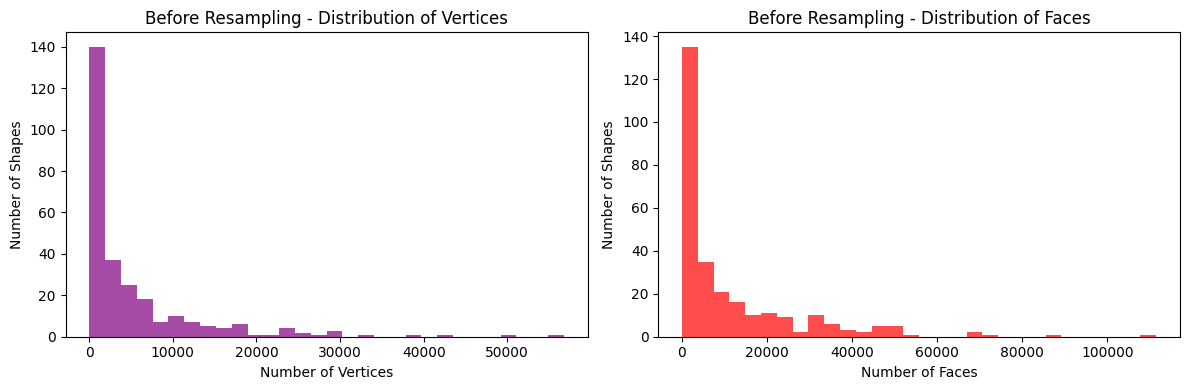


################### Processing batch 1
Refining low complexity mesh (Current vertices: 424)...
Target reached: 4844 vertices (within 5% of 5000).
Refining low complexity mesh (Current vertices: 1242)...
Target reached: 5151 vertices (within 5% of 5000).
Refining low complexity mesh (Current vertices: 724)...
Target reached: 5127 vertices (within 5% of 5000).
Simplifying high complexity mesh (Current vertices: 12164)...
Target reached: 5096 vertices (within 5% of 5000).
Refining low complexity mesh (Current vertices: 12164)...
Target reached: 4767 vertices (within 5% of 5000).
Simplifying high complexity mesh (Current vertices: 12362)...
Target reached: 5249 vertices (within 5% of 5000).
Refining low complexity mesh (Current vertices: 12362)...
------------------> Warning: Could not reach target vertex count after 10 iterations. Final vertex count: 7797.

Refining low complexity mesh (Current vertices: 5675)...
------------------> Warning: Could not reach target vertex count after 10 i

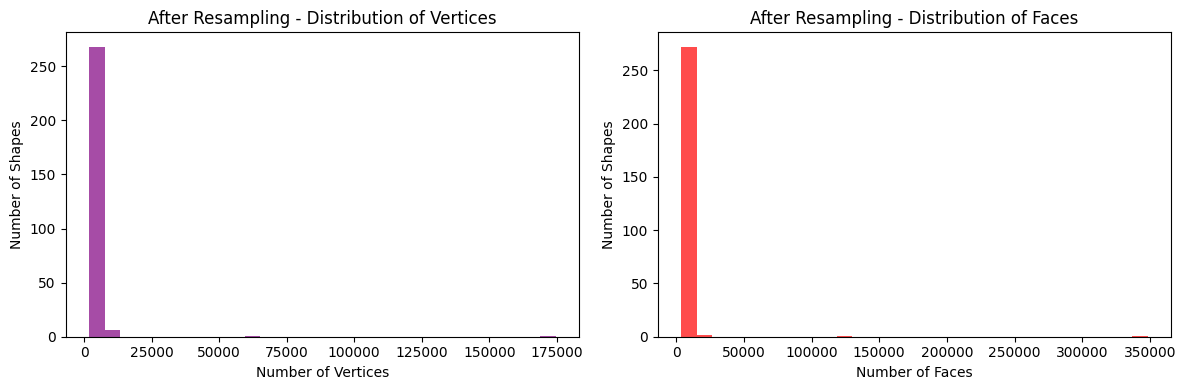

Statistics comparison:

Vertices:
Before Resampling:
count      276.000000
mean      5275.126812
std       8236.467231
min         16.000000
25%        624.000000
50%       1850.000000
75%       5990.750000
max      56754.000000
Name: vertices, dtype: float64

After Resampling:
count       276.000000
mean       6125.257246
std       10809.790575
min        1842.000000
25%        4892.750000
50%        5257.500000
75%        5705.250000
max      174523.000000
Name: vertices, dtype: float64

Faces:
Before Resampling:
count       276.000000
mean      11321.130435
std       16120.662771
min          16.000000
25%        1194.000000
50%        4184.500000
75%       14851.750000
max      111471.000000
Name: faces, dtype: float64

After Resampling:
count       276.000000
mean      11579.605072
std       21560.940186
min        3676.000000
25%        9160.000000
50%       10040.000000
75%       10706.750000
max      348281.000000
Name: faces, dtype: float64


0 OUTLIER meshes skipped


In [8]:
def main(overwrite=False):

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    original_csv_path = os.path.join(OUTPUT_DIR, "shapes_data.csv")
    resampled_csv_path = os.path.join(OUTPUT_DIR, "resampled_shapes_data.csv")

    # Handle original shapes data
    if not os.path.exists(original_csv_path) or overwrite:
        print("Analyzing database and collecting statistics...")
        shapes_data = analyze_database(DATASET_PATH)
        shapes_data_df = pd.DataFrame(shapes_data)
        shapes_data_df.to_csv(original_csv_path, index=False)
        print(f"Original shapes data saved to {original_csv_path}")
    else:
        shapes_data_df = pd.read_csv(original_csv_path)
        print(f"Loaded existing original shapes data from {original_csv_path}")

    plot_distribution(shapes_data_df, "Before Resampling")

    # Handle resampled shapes data
    if not os.path.exists(RESAMPLED_SHAPES_DIR) or overwrite:
        os.makedirs(RESAMPLED_SHAPES_DIR, exist_ok=True)

        # Process meshes in batches
        if USE_FULL_DATA:
          batch_size = 500
        else:
          batch_size = 100

        skipped_shapes_list = []

        for i in range(0, len(shapes_data_df), batch_size):
            print(f"\n################### Processing batch {i//batch_size + 1}")
            batch = shapes_data_df.iloc[i:i+batch_size]
            _, skipped_batch = process_meshes(batch, RESAMPLED_SHAPES_DIR)
            skipped_shapes_list.append(skipped_batch)

        print(f"Resampled shapes saved to {RESAMPLED_SHAPES_DIR}")

        # Save skipped shapes data
        skipped_df = pd.concat(skipped_shapes_list, ignore_index=True)
        skipped_csv_path = os.path.join(OUTPUT_DIR, "skipped_shapes_data.csv")
        skipped_df.to_csv(skipped_csv_path, index=False)
        print(f"Skipped shapes data saved to {skipped_csv_path}")
    else:
        print(f"Resampled shapes folder {RESAMPLED_SHAPES_DIR} already exists. Analyzing existing resampled shapes.")

    print() # empty line
    # Analyze the resampled shapes to get updated vertex and face counts
    print("Analyzing resampled database and collecting statistics...")
    resampled_shapes_data = analyze_database(RESAMPLED_SHAPES_DIR)
    resampled_shapes_df = pd.DataFrame(resampled_shapes_data)

    # Save or update the resampled shapes data
    resampled_shapes_df.to_csv(resampled_csv_path, index=False)
    print(f"Resampled shapes data saved to {resampled_csv_path}")

    plot_distribution(resampled_shapes_df, "After Resampling")
    compare_statistics(shapes_data_df, resampled_shapes_df)



if __name__ == "__main__":
    main(overwrite=True)  # Set to True if you want to overwrite existing files and folders
    print(f"\n\n{COUNTER} OUTLIER meshes skipped")


In [9]:
#pymeshlab.filter_list()